(gravity-code)=

# Unconstrained Gravity Inversion

This section demonstrates the processing and inversion of the **Forrestania gravity dataset** using purely open-source packages.

For an equivalent and streamlined version, see the parent case study here:  
👉 [Forrestania Case Study](forrestania-main)

> 💡 **Note**:  
> The steps taken in this tutorial are strongly based on the official [SimPEG Tutorials](https://simpeg.xyz/user-tutorials/).

```{figure} ../images/landing.png
---
name: Landing Image
---
```


```{table}
| **Authors** |  |
|  :--- | :--- |
| [Polyanna Rowe](https://github.com/polyye) |  polyannar@mirageoscience.com |
| [Dominique Fournier](https://github.com/domfournier) |  dominiquef@mirageoscience.com |
```

## Import Packages

In [1]:
# Import necessary Python libraries for data handling and visualization
import os
import zipfile
from pathlib import Path
from tempfile import mkdtemp

# Import CET colormaps
import colorcet as cc
import discretize
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas
import scipy as sp

# Import SimPEG library
import simpeg
from discretize import TreeMesh
from geoh5py import Workspace, objects
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
from PIL import Image
from scipy.interpolate import griddata
from simpeg import (
    dask,  # Parallel version of the code
    potential_fields,
)
from simpeg.maps import InjectActiveCells
from simpeg.utils import plot2Ddata

# Mira Geoscience specific libraries
from simpeg_drivers import assets_path

## Geological Setting

See the [Forrestania - Geology](forrestania-geology) section for more details.

## Data Preparation

In this step, we will **import and format** the necessary datasets using various **open-source geoscience libraries**.

---

### Download and Unzip the Dataset

Before we can work with the data, we need to **unzip the dataset package** and load the files into usable formats.

The zipped package contains the following files:

-  **Ground gravity survey**  📍  
  `Forrestania_Gravity_Station_trim_.csv`

-  **Digital Elevation Model (DEM)**  🗺️  
  `Forrestania_SRTM1 Australia_MGA50.tiff`

In [2]:
# Create a temporary directory for extracting the zip contents
temp_dir = Path(mkdtemp())
print(f"Temporary extraction folder created at: {temp_dir}")

# Locate the zip file using Mira Geoscience simpeg_drivers' built-in asset_path utility
file = assets_path() / r"Case studies/Forrestania_SRTM1 Australia_MGA50_CSV.zip"

# Print the resolved path to confirm where the file is located on disk
print(f"Dataset path: {file}")

# Extract all contents of the zip file into the temporary directory
with zipfile.ZipFile(file, "r") as zf:
    zf.extractall(temp_dir)
    print(f"Extracted {len(zf.namelist())} files to {temp_dir}")

# List the extracted files for verification
files = list(temp_dir.iterdir())
print("Extracted files:")
for f in files:
    print(f" - {f.name}")

Temporary extraction folder created at: C:\Users\dominiquef\AppData\Local\Temp\tmpzxv6f7l5
Dataset path: C:\Users\dominiquef\Documents\GIT\mira\simpeg-drivers\simpeg_drivers-assets\Case studies\Forrestania_SRTM1 Australia_MGA50_CSV.zip
Extracted 3 files to C:\Users\dominiquef\AppData\Local\Temp\tmpzxv6f7l5
Extracted files:
 - 60472_AOI4.csv
 - Forrestania_Gravity_Station_trim_.csv
 - Forrestania_SRTM1 Australia_MGA50.tiff


---
### Processing Elevation Data

In this step, we'll use Mira Geoscience's `geoh5py` library to read and process the elevation data stored in a GeoTIFF file.

---

#### Step 1: Convert the GeoTIFF to a 2D Grid

We’ll leverage `geoh5py`'s utilities to:

- Read the **GeoTIFF** as a `geo_image` object
- Convert it to a **2D grid** of elevation values
- Preserve the **spatial referencing**, including geographic coordinates

This gives us a structured **DEM** ready for further visualization and interpolation.


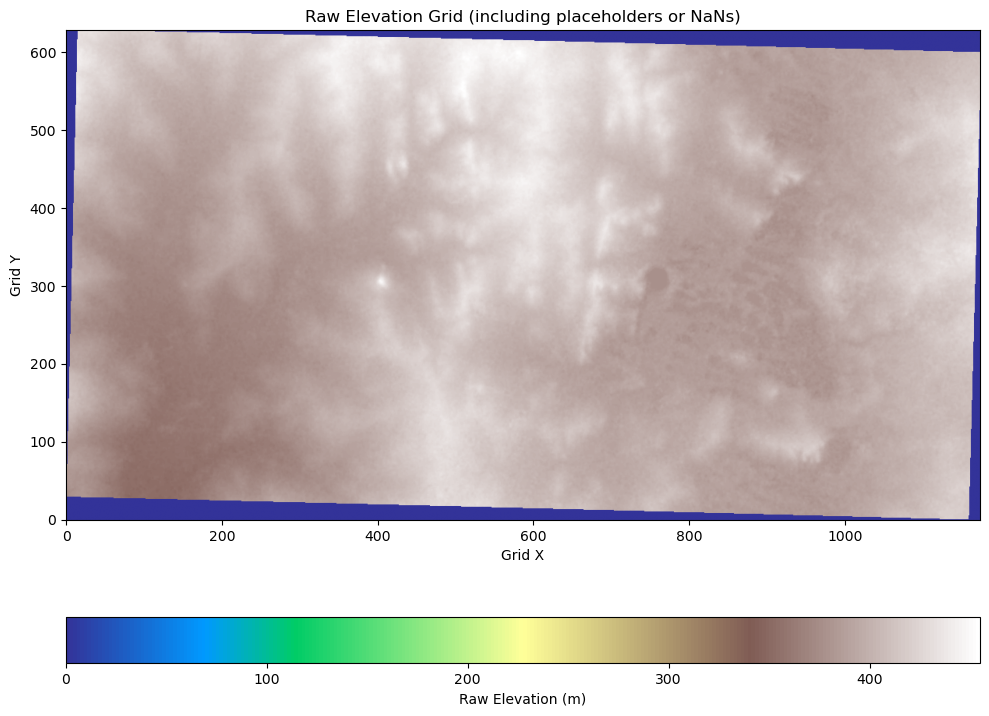

In [3]:
# Create a geoh5py workspace (in-memory) for loading the elevation data
ws = Workspace()

# Load the GeoTIFF as a GeoImage object from the extracted files
geotiff = objects.GeoImage.create(
    ws, image=str(next(file for file in files if "SRTM1" in file.name))
)

# Register the geospatial reference system using TIFF metadata
geotiff.georeferencing_from_tiff()

# Convert the GeoImage into a structured 2D grid object
grid = geotiff.to_grid2d()
elevations = grid.children[0].values  # Flat array of elevation values

# Reshape and visualize the elevation data
elev_image = elevations.reshape(grid.shape, order="F").T

# Plot the elevation data
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(elev_image, cmap="terrain", origin="lower")

# Add colorbar and annotations
cbar = plt.colorbar(im, orientation="horizontal", pad=0.1)
cbar.set_label("Raw Elevation (m)")

ax.set_title("Raw Elevation Grid (including placeholders or NaNs)")
ax.set_xlabel("Grid X")
ax.set_ylabel("Grid Y")
plt.tight_layout()
plt.show()

#### Clean Up Invalid Elevation Values
We also need to remove the zeros or placeholder values from the rotated DEM.

In [4]:
# Check minimum elevation value
print(f"Minimum elevation value: {np.nanmin(elevations)}")

Minimum elevation value: 1.1754943508222875e-38


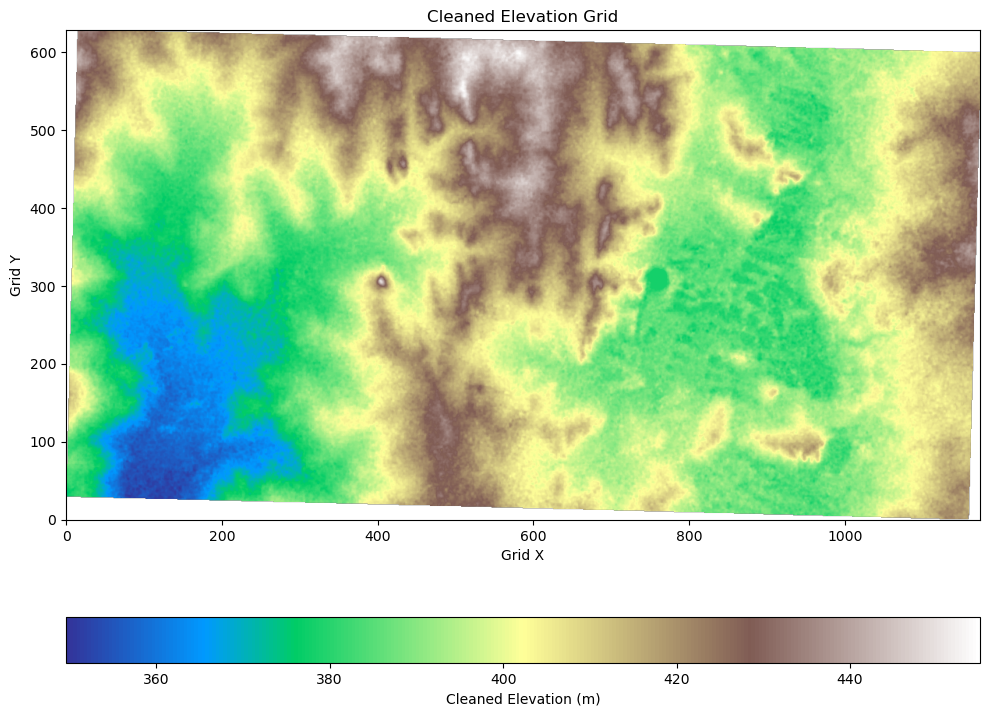

In [5]:
# Replace placeholder elevation values (near zero) with NaN
# These extremely small values typically represent "no data" in the raster
no_data_mask = np.abs(elevations) < 2e-38
elevations = np.where(no_data_mask, np.nan, elevations)

# Visualize the cleaned elevation data
fig, ax = plt.subplots(figsize=(10, 10))
cleaned_elev_image = elevations.reshape(grid.shape, order="F").T

im = ax.imshow(cleaned_elev_image, cmap="terrain", origin="lower")

# Add colorbar and axis labels
cbar = plt.colorbar(im, orientation="horizontal", pad=0.1)
cbar.set_label("Cleaned Elevation (m)")

ax.set_title("Cleaned Elevation Grid")
ax.set_xlabel("Grid X")
ax.set_ylabel("Grid Y")
plt.tight_layout()
plt.show()

### Final DEM Numpy Array

With the elevation grid cleaned and spatially referenced, we now combine the X and Y coordinates of the grid centroids with the corresponding elevation values to form a complete **DEM numpy array** array.

The resulting array has the structure:

In [6]:
# Final DEM array construction: [X, Y, Elevation]
# Combine the grid centroids (X, Y) with the cleaned elevation values
dem = np.c_[grid.centroids[:, :2], elevations]

# Preview the result
print(f"DEM shape: {dem.shape} (rows: points, columns: [X, Y, Elevation])")

DEM shape: (738446, 3) (rows: points, columns: [X, Y, Elevation])


---  

### Inspecting the Gravity Data

We will use the `pandas` library to read the ground gravity survey data from the provided CSV file.

This dataset contains **station-based gravity measurements** along with spatial and elevation data.

#### About the Dataset

Since publicly available ground gravity data in this region lack the resolution required to image the target anomaly, we use a **synthetic dataset** for this exercise.

- The gravity response was generated by **forward modeling an iso-shell** derived from a completed magnetic inversion.
- **Random noise** were added to make the synthetic dataset more realistic and challenging for inversion.


> 💡 **Note:**  
> This synthetic gravity dataset has already been:
> - **Positioned at surface elevation**
> - **Terrain corrected** using a bulk density of **2.67 $g/cm^3$**
> - Values are expressed in **milligals (mGal)**

As a result, **no additional preprocessing** (e.g., terrain correction or elevation filtering) is needed. The data is ready to be used directly for inversion and modeling.


In [7]:
# Read the gravity CSV with pandas

grav_dataframe = pandas.read_csv(
    next(file for file in files if "Gravity" in file.name)
)  # Command 'next' returns the first file that matches the condition.

# Preview the dataset
print("Gravity survey data preview:")
grav_dataframe

Gravity survey data preview:


,X,Y,Z,FGrav_mgal
0,748151.81,6416320.5,380.31,0.147
1,748034.16,6416308.5,380.62,0.233
2,747994.06,6416313.0,380.57,0.284
3,747709.00,6416310.0,380.26,0.519
4,747416.75,6416310.0,375.74,0.359
...,...,...,...,...
987,748056.18,6419203.5,382.12,0.037
988,748379.12,6419225.5,381.77,-0.022
989,748666.29,6419202.5,383.24,-0.015
990,748956.78,6419211.5,382.97,-0.012


In [8]:
# Convert gravity DataFrame to NumPy array
grav_survey = grav_dataframe.to_numpy()

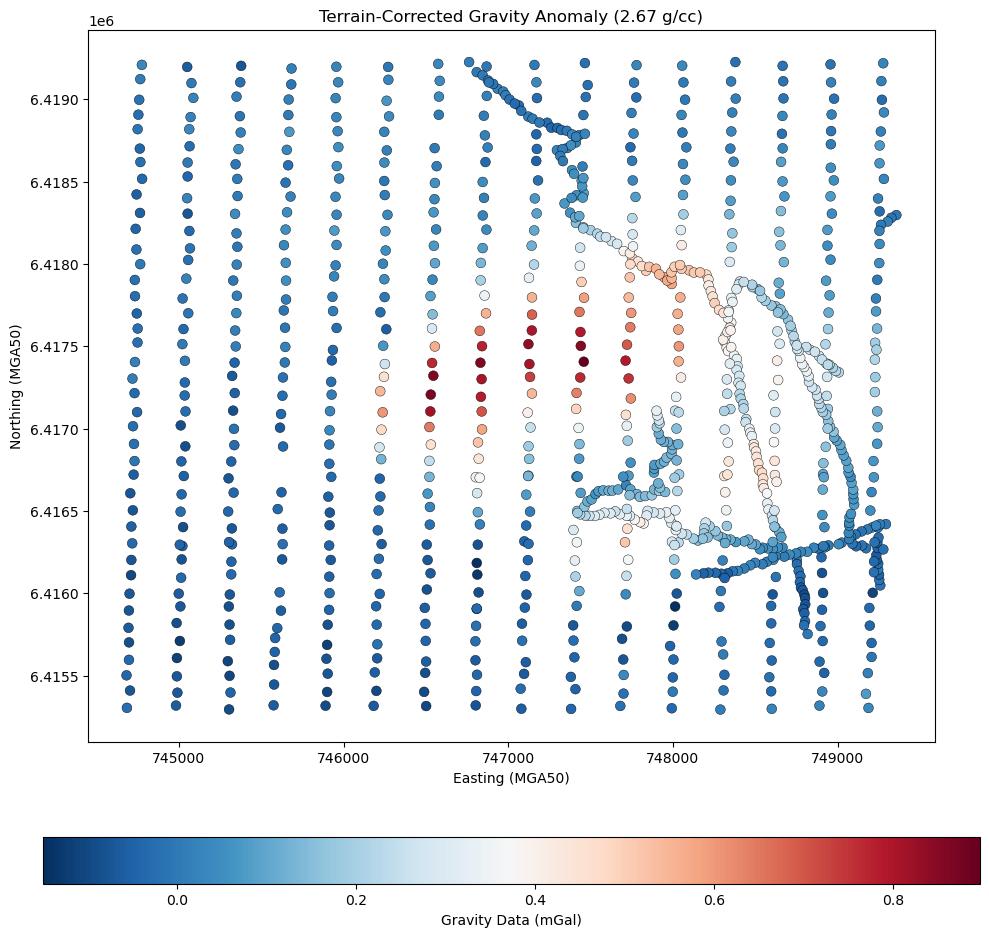

In [9]:
# Plot gravity data points with black outlines
fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(
    grav_survey[:, 0],  # Easting
    grav_survey[:, 1],  # Northing
    c=grav_survey[:, -1],  # Gravity values (mGal)
    cmap="RdBu_r",
    s=50,
    marker="o",
    edgecolors="black",  # Add black outline to each point
    linewidth=0.3,  # Optional: thinner edge line
)

# Add colorbar for gravity values
cbar = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cbar.set_label("Gravity Data (mGal)")

# Plot styling
ax.set_aspect("equal")
ax.set_title("Terrain-Corrected Gravity Anomaly (2.67 g/cc)")
ax.set_xlabel("Easting (MGA50)")
ax.set_ylabel("Northing (MGA50)")
plt.tight_layout()
plt.show()

## Inversion

We now proceed with the inversion of the ground gravity data.  
Our objective is to model the **shape and position** of subsurface geological units in 3D based on **density contrasts**.

---

### Create a Mesh

To prepare for inversion, we need to discretize the subsurface into a 3D mesh (grid of cells) under the following constraints:

- Use **as few cells as possible** to remain computationally efficient
- Ensure **high resolution** in target areas to capture small features

We achieve both goals using an **adaptive octree mesh**, which allows finer resolution where needed and coarser discretization elsewhere.

```{figure} ../images/octree_grid.png
Top-down view of the adaptive octree mesh. Smaller (refined) cells are usually concentrated around magnetic measurement points, where model resolution matters most.
```

We will use the function `discretize.utils.mesh_builder_xyz` to create the **adaptive octree mesh** around our gravity stations and topography.

This function builds a 3D mesh from a cloud of points (`xyz`) and a base cell size (`h`). It supports both tensor and tree (octree) meshes and handles padding, depth control, and expansion automatically.

Function:
```python
discretize.utils.mesh_builder_xyz(xyz, h, padding_distance=None, base_mesh=None, depth_core=None, expansion_factor=1.3, mesh_type='tensor', tree_diagonal_balance=None)
```
Key parameters:
- `xyz`: Input point cloud (e.g., gravity stations)
- `h`: Base cell size in x, y, z
- `depth_core`: Depth of the high-resolution core
- `padding_distance`: `[[W, E], [N, S], [Down, Up]]` padding around the core (default: no padding)
- `mesh_type='tree'`: Use octree mesh type.
- `expansion_factor=1.3`: For tensor mesh type only.

```{figure} ../images/diag_balance.png
TreeMesh with and without diagonal balance.
```

> 💡 **Note**:  
> - Disabling **diagonal balance** allows abrupt transitions between octree levels (e.g., from 1 to 3), reducing cell count but potentially decreasing simulation accuracy when solving partial-differential equations.  
> - **Padding** is usually added to capture *long-wavelength signals* and *minimize edge effects*. A common guideline is to pad by at least the lateral extent of the data coverage. Here, the target anomaly is well-centered and spectrally isolated, with no significant regional trends. Therefore, padding is omitted to reduce computational cost.



In [10]:
# Define the base cell size in x, y, and z directions (in meters)
# Typically set to half the survey flight height or data resolution.
# Here, we use 30 m (matching half the magnetic survey flight height)
# to ensure comparability of results between this and the magnetic inversion.
dh = 30  # Base cell size in meters (same in x, y, and z)
base_cells = [dh, dh, dh]  # [dx, dy, dz] base mesh cell width in meters

# Create base TreeMesh (Octree) covering the full extent of the data
# Start with no refinements
grav_octree = discretize.utils.mesh_builder_xyz(
    grav_survey[:, :3],  # Use gravity dataset coordinates for domain extent
    base_cells,  # Base cell size in X, Y, and Z directions
    mesh_type="tree",  # Use adaptive octree mesh
    depth_core=2000,  # The mesh will be at least as deep as 2000 m
    # padding_distance=[[2000,2000],[1750,1750],[2000,500]]   # Padding (not used here, but can be specified for padding around the domain)
)

# Refine the mesh around receiver locations (gravity stations)
# Function designed for points specifically
grav_octree.refine_points(
    grav_survey[:, :3],  # Refine around station points
    level=-1,  # Start at the (last) highest level, i.e., the base cell size.
    padding_cells_by_level=[
        6,
        6,
        6,
    ],  # Number of cells at 30 m, 60 m and 120 m, i.e., 6 cells for each level 1, 2, and 3
    finalize=False,  # Don't finalize yet. We'll add refinement to topography.
)

# Refine along topography
# Function designed for surfaces specifically
grav_octree.refine_surface(
    dem,
    level=-3,  # Start at level -3, i.e., only refine at 120 m around DEM.
    padding_cells_by_level=[1],  # Number of cells at 120 m, which is level -3
    finalize=True,  # Complete the mesh on our last call
)

### Define Active Cells

In gravity modeling, **only cells below the Earth's surface** influence the simulated gravity response. These are called **active cells**. In contrast, **air cells** above the surface do not contribute and are excluded from the forward simulation and inversion.

SimPEG uses a boolean mask to identify active versus inactive cells. This is typically done using the `discretize.utils.active_from_xyz` utility, which compares the mesh to the topography.

- **Active cells**: below topography, used in forward simulation/inversion.
- **Inactive cells**: above topography, ignored to save computation.

The result is a `bool` array (our object named `active`) the same size as the number of mesh cells, indicating which are active.

In [11]:
# Identify active (subsurface) cells based on the DEM surface
# This flags all cells whose centers lie below the topography
active = discretize.utils.active_from_xyz(grav_octree, dem)

# Count the number of active (non-air) cells
n_actives = int(active.sum())
print(f"Number of active (non-air) cells: {n_actives}")

Number of active (non-air) cells: 227387


### Plot a mesh slice 

In [12]:
print(
    f"Cheking Y range of stations: min = {grav_survey[:, 1].min()}, max = {grav_survey[:, 1].max()}"
)

Cheking Y range of stations: min = 6415294.0, max = 6419225.5


In [13]:
# Create a model with value 0 for active and -999 for inactive cells (as flag) for plotting the TreeMesh
# This will (only) be used to visualize the active cells in the mesh

# grav_octree.nC returns the total number of cells, we create a mesh with -999 assigned to all cells
full_model = np.full(grav_octree.nC, -999.0)

# Then we set value 0 for active cells only
full_model[active] = 0.0

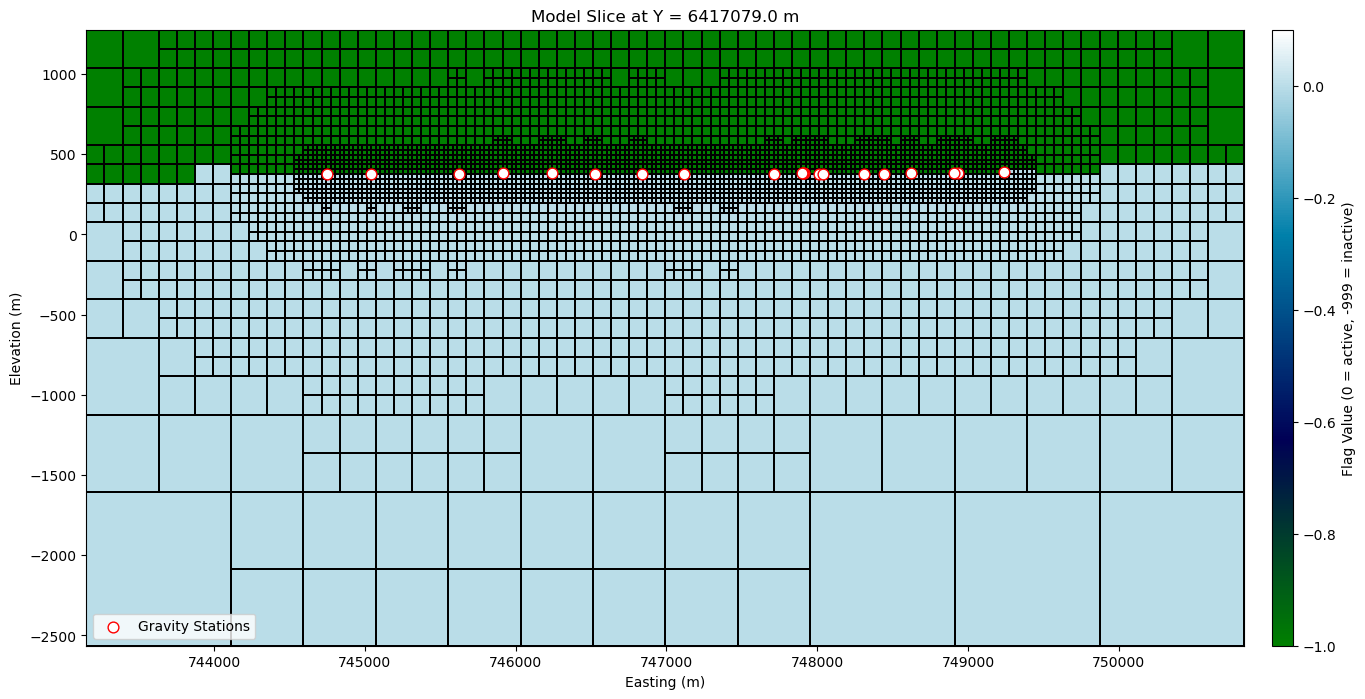

In [14]:
# Plot TreeMesh Y-slice with gravity stations near the slice
fig, ax = plt.subplots(figsize=(18, 8))
# Get index of slice closest to median Y of gravity data
y_slice_idx = np.argmin(
    np.abs(grav_octree.cell_centers_y - np.median(grav_survey[:, 1]))
)
# Corresponding Y location for annotation
y_val = grav_octree.cell_centers_y[y_slice_idx]

# Plot model slice
norm = mpl.colors.Normalize(vmin=-1.0, vmax=0.1)
cmap = mpl.cm.ocean
grav_octree.plot_slice(
    full_model,
    normal="Y",
    ind=y_slice_idx,
    ax=ax,
    grid=True,
    pcolor_opts={
        "cmap": cmap,
        "norm": norm,
        "linewidth": 0.1,  # linewidth to show mesh grid
    },
)

# Add gravity stations near the slice
tol = grav_octree.h[1].min()  # Minimum cell size in Y direction
mask = (
    np.abs(grav_survey[:, 1] - y_val) < tol
)  # Mask to select points within tolerance of the slice
ax.scatter(
    grav_survey[mask, 0],
    grav_survey[mask, 2],
    s=60,
    c="white",
    edgecolors="red",
    label="Gravity Stations",
)

ax.set(
    title=f"Model Slice at Y = {y_val:.1f} m",
    xlabel="Easting (m)",
    ylabel="Elevation (m)",
)
ax.legend(loc="lower left", fontsize=10)

# Add colorbar
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    pad=0.02,
    aspect=30,
    label="Flag Value (0 = active, -999 = inactive)",
)
plt.show()

### Define Mapping from the Model to Active Cells

In SimPEG, the **model** refers to a set of parameters, which are *not always* the same as physical property values directly defined on the mesh. For example, the model might represent:

- Logarithms of physical properties (e.g., `log(conductivity)`)
- Parametric shapes (e.g., layers, ellipsoids)
- Or, in our case, **density contrasts** in active cells.

To connect these model parameters to the physical property values on the mesh, SimPEG uses **mappings**, defined through the `simpeg.maps` module.

In this case, we are inverting for **density contrast values** directly within the active cells of the mesh. Therefore, we use an `IdentityMap`, i.e. a simple, one-to-one mapping between model parameters and active cell values.

In [15]:
# Define mapping from model to active cells. Our model consists of a density
# contrast value (to be defined) for each cell below the Earth's surface.

model_map = simpeg.maps.IdentityMap(nP=n_actives)

### Define the Reference and Starting Models

In SimPEG, we define two important models for inversion:


- **Starting model (`m_start`):** Provides an initial guess for the inversion but doesn't need to resemble the true subsurface. For gravity inversion using a `linear` integral formulation, the choice of starting model has minimal impact on the result. However, it **must not be all zeros**, as that would prevent gradient computation during the first iteration. A small constant value is often used.

- **Reference model (`m_ref`):** Encodes prior geologic knowledge or expectations about the subsurface. If no such prior is available and background structures has been removed from the gravity data, the reference model is typically zero.

> 💡 **Note**:  
> Both models are defined only over **active cells** (i.e., below surface) and must be 1D NumPy arrays with length equal to the `number of active cells`.  
> Density contrast values are expressed in units of $g/cm^3$.
> In linear least-square problems, the inversion converges to a unique solution regardless of the starting point, unlike nonlinear cases where the starting model can affect convergence.

In [16]:
# Reference model: zero density contrast (background assumption)
m_ref = np.zeros(n_actives)

# Starting model: small uniform density contrast across all active cells as an initial guess
m_start = np.ones(active.sum()) * 1e-4

# Print the starting model shape and values for verification
print(
    f"Starting model shape (active cells): {m_start.shape}, with {m_start} density contrast (g/cc) model\n"
)

# Print the reference model shape and values for verification
print(
    f"Reference model shape (active cells): {m_ref.shape}, with {m_ref} density contrast (g/cc) model"
)

Starting model shape (active cells): (227387,), with [0.0001 0.0001 0.0001 ... 0.0001 0.0001 0.0001] density contrast (g/cc) model

Reference model shape (active cells): (227387,), with [0. 0. 0. ... 0. 0. 0.] density contrast (g/cc) model


### Define the Survey

Next, we define *survey configuration*. Gravity surveys are relatively straightforward to define. The setup includes three core objects:

- **Receivers**: specify the 3D coordinates $[X, Y, Z]$ of each observation location and the physical quantity being measured (e.g., the vertical gravity component `gz`). We are not using gravity gradient data in this case.  
- **Source field**: although gravity is a **passive method** (i.e., there’s no physical source injecting energy), SimPEG still uses a `SourceField` object to associated the receivers and measured component (e.g., `"gz"`) with the source field.  
- **Survey**: brings the receivers and source together into a structure that the simulation uses.  


> 💡 **Note**: 
>   
> The `SourceField` object is required by the `potential_fields` simulation framework.



In [17]:
# Use the measured data locations and components to define receivers for the entire survey in one step
# The set of receivers, even if it's only 1, are organized within a list
receiver_list = potential_fields.gravity.receivers.Point(
    grav_survey[:, :3],  # [X, Y, Z] coordinates
    components=[
        "gz"
    ],  # Component(s) of the field we want to simulate as strings within a list
)

# Defining the source - For gravity surveys, we simply need to specific the list of
# receivers associated with the source field
source_field = potential_fields.gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = potential_fields.gravity.survey.Survey(source_field)

In [18]:
# check the characteristics of the survey

print(f"Number of data points (nD): {survey.nD}")
print("\nSource field object:")
print(survey.source_field)
print("\nReceiver object:")
print(survey.source_field.receiver_list)
print("\nFirst 5 receiver locations (X, Y, Z):")
print(receiver_list.locations[:5, :])

Number of data points (nD): 992

Source field object:

Receiver object:

First 5 receiver locations (X, Y, Z):
[[7.4815181e+05 6.4163205e+06 3.8031000e+02]
 [7.4803416e+05 6.4163085e+06 3.8062000e+02]
 [7.4799406e+05 6.4163130e+06 3.8057000e+02]
 [7.4770900e+05 6.4163100e+06 3.8026000e+02]
 [7.4741675e+05 6.4163100e+06 3.7574000e+02]]


### Define the Forward Simulation

We now define **how to simulate the physical (forward) response** of our model at the receiver locations.

In SimPEG, this is done by creating a simulation object. In this case, using the 3D integral formulation. 

The simulation object must be linked to:
- The `survey` (receiver locations and data type)
- The `mesh` (discretization of the model domain)
- The `active cells` (subsurface-only)
- The `model mapping` (from model parameters to physical properties)

These elements are passed as arguments to the `simulation` class. Additional parameters can be configured to control solver behavior and memory usage.

In [19]:
# Define the forward simulation
simulation = potential_fields.gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=grav_octree,
    active_cells=active,
    rhoMap=model_map,
)

### Define Data and Uncertainties

We can create a `SimPEG.Data` that defines the observed data and uncertainties.

Uncertainty can be specified in one of two ways:
- A **combination** of `relative_error` (percent of each datum) and `noise_floor` (fixed small value to avoid numerical instability near zero)
- A **direct** `standard_deviation` value per datum, which defines the total uncertainty (𝜀) assuming Gaussian noise

By setting `standard_deviation`, we bypass the combination of relative and floor errors and explicitly provide the expected noise level.

> 💡 **Note**:  
> - For gravity data, the uncertainty floor can be chosen based on some knowledge of the instrument error, or as some fraction of the largest anomaly value.  
> - In this tutorial, we use $2.5$% of the maximum gravity anomaly. For gravity gradiometry, different floors may be set per component.
> - In SimPEG, gravity anomaly values are in units `mGal`.

### Z Convention in Gravity Data

* SimPEG uses a `right-handed coordinate system` to simulate `gravity anomaly data` where **_Z is positive upward!!!_** Be aware of this when using gravity data to infer the locations of more and less dense structures: 
    * For example, a denser structure increases gravitational pull downward (−Z), resulting in a negative anomaly in SimPEG's convention. 


In [20]:
# Observed data
dobs = grav_survey[:, -1] * -1  # Observed gravity values (mGal)
# using righ-handed coordinate system required in SimPEG
# Assigning uncertainty
maximum_anomaly = np.max(np.abs(dobs))  # Maximum absolute value of the gravity anomaly
floor_uncertainty = 0.025 * maximum_anomaly  # Fixed uncertainty (noise floor)
uncertainties = floor_uncertainty * np.ones(
    np.shape(dobs)
)  # Assign a constant uncertainty to all data points

print(f"Absolute Maximum Anomaly: {maximum_anomaly} mGal")
print(f"Assigned Uncertainty: {floor_uncertainty} mGal")

# Create a Data object linking the survey, observations, and assumed noise level
data = simpeg.Data(
    survey=survey,  # The survey object defining the survey geometry; i.e. sources, receivers, data type.
    dobs=dobs,  # Observed gravity values (mGal)
    standard_deviation=uncertainties,  # Fixed uncertainty (standard deviation of Gaussian noise) per datum in data units (mGal)
)

Absolute Maximum Anomaly: 0.897 mGal
Assigned Uncertainty: 0.022425 mGal


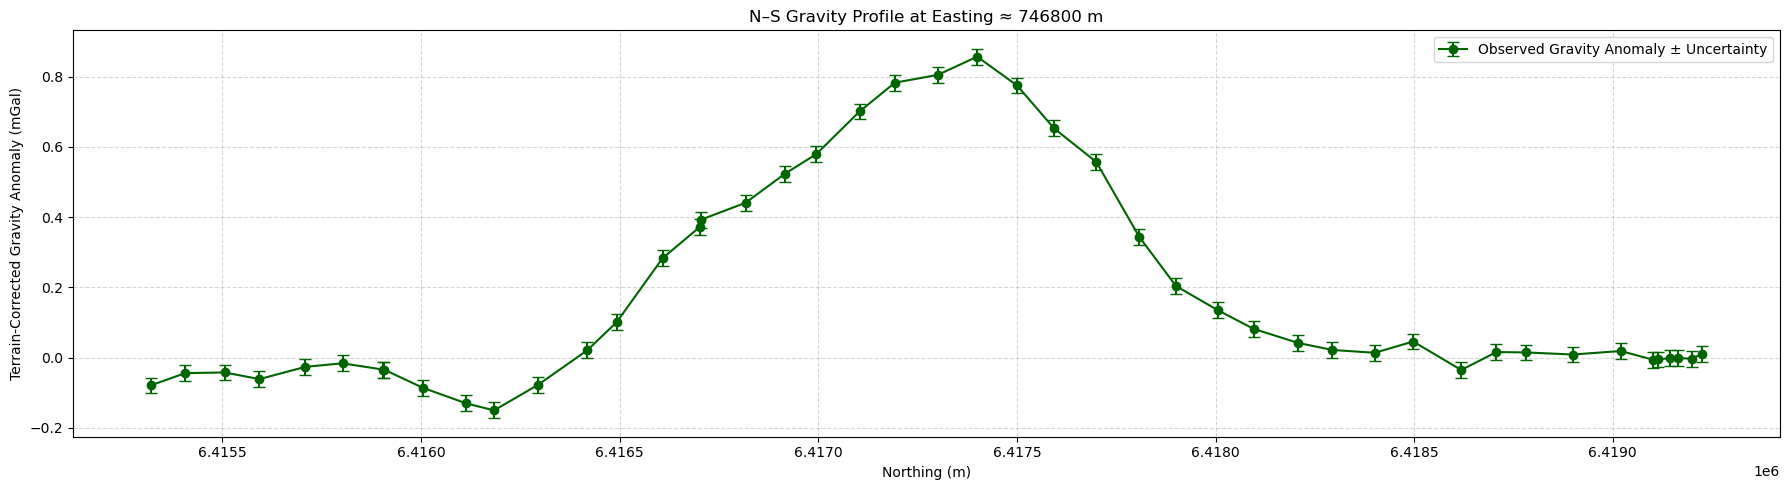

In [21]:
# Plot gravity profile and assigned uncertainties along a N-S profile

# Choose an Easting value to extract the N-S profile
target_easting, tol = 746800, 100  # X coordinate and tolerance in meters

# Select points near the vertical profile
mask = np.abs(grav_survey[:, 0] - target_easting) < tol
y, g_obs, g_err = grav_survey[mask, 1], grav_survey[mask, -1], uncertainties[mask]

# Sort by Northing (for better plot)
sort_idx = np.argsort(y)
y = y[sort_idx]
g_obs = g_obs[sort_idx]
g_err = g_err[sort_idx]

# Plot
plt.figure(figsize=(18, 5))
plt.errorbar(
    y,
    g_obs,
    yerr=g_err,
    fmt="o-",
    color="darkgreen",
    capsize=4,
    label="Observed Gravity Anomaly ± Uncertainty",
)

plt.title(f"N-S Gravity Profile at Easting ≈ {target_easting} m")
plt.xlabel("Northing (m)")
plt.ylabel("Terrain-Corrected Gravity Anomaly (mGal)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

---

### The Objective Function

#### Data Misfit Function

In inversion, we seek a model $ \mathbf{m} $ that best explains the observed data.  
This is quantified by the **data misfit function**.

The objective function is:

$$
\phi(m) = \phi_d + \beta \, \phi_m
$$

Where:  
- $ \phi_d $ is the **data misfit**  
- $ \phi_m $ is the **regularization**  
- $ \beta $ balances data fit and model complexity

The data misfit $ \phi_d $, using a least-squares formulation, is defined as:

$$
\phi_d = \left\| W_d \left( \mathbf{d}_{\text{obs}} - \mathbf{d}_{\text{pred}} \right) \right\|_2^2
$$

With:  
- $ \mathbf{d}_{\text{obs}} $ = observed data  
- $ \mathbf{d}_{\text{pred}} $ = predicted data from the forward model 
- $ W_d $ = diagonal weighting matrix, typically $ 1 / \epsilon_i $, where $ \epsilon_i $ is the uncertainty for each datum


In [22]:
# Define the data misfit function
# Quantifies the difference between observed and predicted data
# using the L2 norm, which is suitable for Gaussian noise assumptions.
data_misfit = simpeg.data_misfit.L2DataMisfit(data=data, simulation=simulation)

#### Regularization Function

To stabilize the inversion and constrain the solution, we add a **regularization term $\phi_m$** that incorporates prior assumptions about the model.

We use SimPEG’s `Sparse` regularizer, which allows a **weighted least squares formulation**. It uses an **Iteratively Reweighted Least Squares (IRLS)** strategy to promote <u>**sparsity**</u> in the model and adapt the weighting during inversion.

The regularization combines:
- A **smallness** term to keep the model close to a reference (here, density contrast equal to 0.0 $g/cm^3$)
- A **smoothness** term to control spatial variations in the x, y, and z directions

In our setup:

- `norms = [0, 2, 2, 2]`
  - `0`-norm for smallness encourages **compact bodies**
  - `2`-norm for smoothness enforces **smooth, continuous changes** in all directions
- `alpha_s`, `alpha_x`, `alpha_y`, `alpha_z` control the relative importance of each term
  - Using the function's defaults for all terms, but these can be adjusted based on prior knowledge or desired model characteristics



In [23]:
# Define the regularization (Sparse + smoothness)
regularization = simpeg.regularization.Sparse(
    mesh=grav_octree,  # The octree mesh used for inversion
    active_cells=active,  # The active cells (subsurface) previously defined
    reference_model=m_ref,  # Our previously assigned zero density contrast model m_ref
    # Smallness term parameters
    # alpha_s=1,                            # Scaling constant for the smallness regularization term
    # Smoothness term parameters
    # alpha_x=1,                            # Scaling constants for the first order smoothness
    # alpha_y=1,                            # along x, y and z, respectively
    # alpha_z=1,                            # If set to None, the scaling constant is set automatically
    # according to the value of the length_scale parameter
    # length_scale_x=1,                     # Multiplier constant for smoothness
    # length_scale_y=1,                     # along x,y,z relative to base scale length
    # length_scale_z=1,                     # These are equal to sqrt(alpha_x/base cell size_x) for component X and so on
    # Model norms
    norms=[0, 2, 2, 2],  # L0 norm for smallness, L2 norm for smoothness (x, y, z)
    # Must all be within the interval [0, 2].
)

### Inversion Directives

In SimPEG, **directives** control various steps during the inversion process, such as setting the trade-off parameter, updating weights, and managing the solver.

Directive objects are stored in a **`list`**, and SimPEG calls them **in sequence** at the start and after each model update.  

Our setup includes:

- **`UpdateIRLS`**  
  Iteratively updates weights for the sparse regularization using **Iteratively Reweighted Least Squares (IRLS)**. This promotes `compact` or `blocky` structures. Here, we allow up to **25 IRLS iterations**.


- **`UpdateSensitivityWeights`**  
  Defines how sensitivity-based weights are computed for regularization. These weights help ensure that all cells of the model have a fair chance of being adjusted during inversion, even if their initial sensitivities are low, accounting for the natural decay in sensitivity with depth or distance from the data. Applied once before inversion (`every_iteration=False`), ensuring all regions are fairly weighted.

- **`BetaEstimate_ByEig`**  
  Sets the initial trade-off parameter $\beta_0$ by analyzing the sensitivity (Jacobian) matrix, which describes how model changes affect the predicted data. It selects the largest eigenvalue of this matrix and multiplies it by `beta0_ratio = 10`, ensuring that the data misfit and regularization term start on comparable scales in the objective function. This avoids overfitting or underfitting early in the inversion and leads to a more stable solution.  

- **`UpdatePreconditioner`**  
  Updates the matrix preconditioner used by the solver to speed up convergence of the linear system.  
  Recomputing it (`update_every_iteration=True`) ensures efficient solving as the model evolves during inversion.

These directives are grouped into a `directives_list` and passed to the inversion routine.  
  
For this inversion with a non-L2 norm, we don’t use the `BetaSchedule` and `TargetMisfit` directives. Here, the beta cooling schedule can be set in the `UpdateIRLS` directive using the `coolingFactor` and `coolingRate` properties. The target misfit for the L2 portion of the IRLS approach can be set with the `chifact_start` property. If not specified, defaults for the function are used.
  

> 💡 **Note**:  
> - **The order matters**. SimPEG will raise an error if directives are incorrectly ordered.
> - A **preconditioner** transforms the inversion system into an equivalent form with better numerical properties, enabling the solver to converge **faster and more reliably**.


In [24]:
# Set up inversion directives

# Directive 1 - Set up IRLS to promote sparsity in the model
update_irls = simpeg.directives.UpdateIRLS(
    # cooling_factor=2,   # Default values but you can decide if you want something different
    # cooling_rate=1,
    # chifact_start=1.0,
    max_irls_iterations=25
)

# Directive 2 - Apply sensitivity-based weighting
sensitivity_weights = simpeg.directives.UpdateSensitivityWeights(every_iteration=False)

# Directive 3 - Estimate initial trade-off parameter β₀ from largest eigenvalue of the Jacobian
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=10)

# Directive 4 - Update preconditioner at every iteration for faster convergence
update_jacobi = simpeg.directives.UpdatePreconditioner(update_every_iteration=True)

# Directive 5 - Track and save output at each iteration
save_out = simpeg.directives.SaveOutputEveryIteration(
    name="iterations_gravity"
)  # Saves in the current working directory

# Directives in required order
directives_list = [
    update_irls,  # IRLS loop for sparsity
    sensitivity_weights,  # Must come before beta
    starting_beta,  # Needs sensitivity weights
    update_jacobi,  # Solver preconditioning
    save_out,  # Save models and predicted data at every iteration
]

### Define the Optimization Algorithm and Run the Inversion

We now configure and run the inversion by combining the components defined earlier.

- **`ProjectedGNCG` optimizer**  
  - A projected gradient-based solver suitable for large linear and/or non-linear problems.  
  - Note that this opimization class allows the user to set upper and lower bounds for the recovered model using the `upper` and `lower` properties inside the function.  
  - Here, we will limit the number of iterations to **25**.

- **`BaseInvProblem`**  
  Combines the **data misfit**, **regularization**, and **optimization strategy** into a single inversion object.

- **`BaseInversion`**  
  Wraps the inversion problem and applies the **directive list** to control updates (e.g., $\beta$, IRLS, preconditioner).

- **Starting model**  
  We start with a uniform model with density contrast of **$1 \times 10^{-4}$ g/cc** across all active cells.


In [25]:
# Define the optimization algorithm
optimizer = simpeg.optimization.ProjectedGNCG(maxIter=25)

# Define an inverse problem, the inversion and run
inv_problem = simpeg.inverse_problem.BaseInvProblem(
    data_misfit, regularization, optimizer
)

# The inversion object
inversion = simpeg.inversion.BaseInversion(inv_problem, directives_list)

# Run the inversion
rec_model = inversion.run(m_start)  # m_start is the initial model previously defined


Running inversion with SimPEG v0.22.2.dev43+gcd269b4c1.d20241026
[########################################] | 100% Completed | 8.71 ss
simpeg.SaveOutputEveryIteration will save your inversion progress as: '###-iterations_gravity-2025-08-07-12-22.txt'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.40e+02  1.01e+05  2.81e+00  1.01e+05    1.11e+06      0              
   1  6.99e+01  8.02e+04  7.29e+01  8.53e+04    4.35e+05      0              
   2  3.49e+01  6.92e+04  1.87e+02  7.58e+04    3.31e+05      0   Skip BFGS  
   3  1.75e+01  5.78e+04  4.24e+02  6.52e+04    2.27e+05      0   Skip BFGS  
   4  8.74e+00  4.62e+04  9.00e+02  5.41e+04    1.45e+05      0   Skip BFGS  
   5  4.37e+00  3.50e+04  1.82e+03  4.30e+04    8.76e+04      0   Skip BFGS  
   6  

## Results

### Analysing Convergence
Plot data misfit and model norms at each iteration to assess convergence and stability.
Keep it in mind that $\phi(m) = \phi_d + \beta \, \phi_m$ and a beta cooling schedule is applied during the inversion.

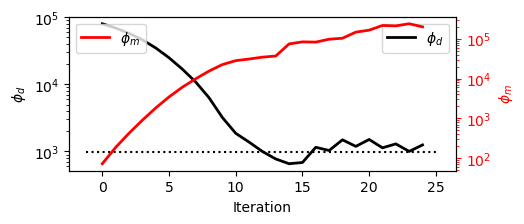

In [26]:
# Plot the data misfit and and model norm evolution across iterations
# Uses SimPEG plotting utilities (basic plotting)
save_out.plot_misfit_curves(dpi=300)

### Data fit

#### Map view

Before interpreting the results, it’s essential to validate the quality of the data fit. We want to make sure that most of the signal is captured, leaving only behind random noise (residuals).

> ⚠️ Without a good fit to the data, any interpretation of the recovered 3D density model may be misleading.

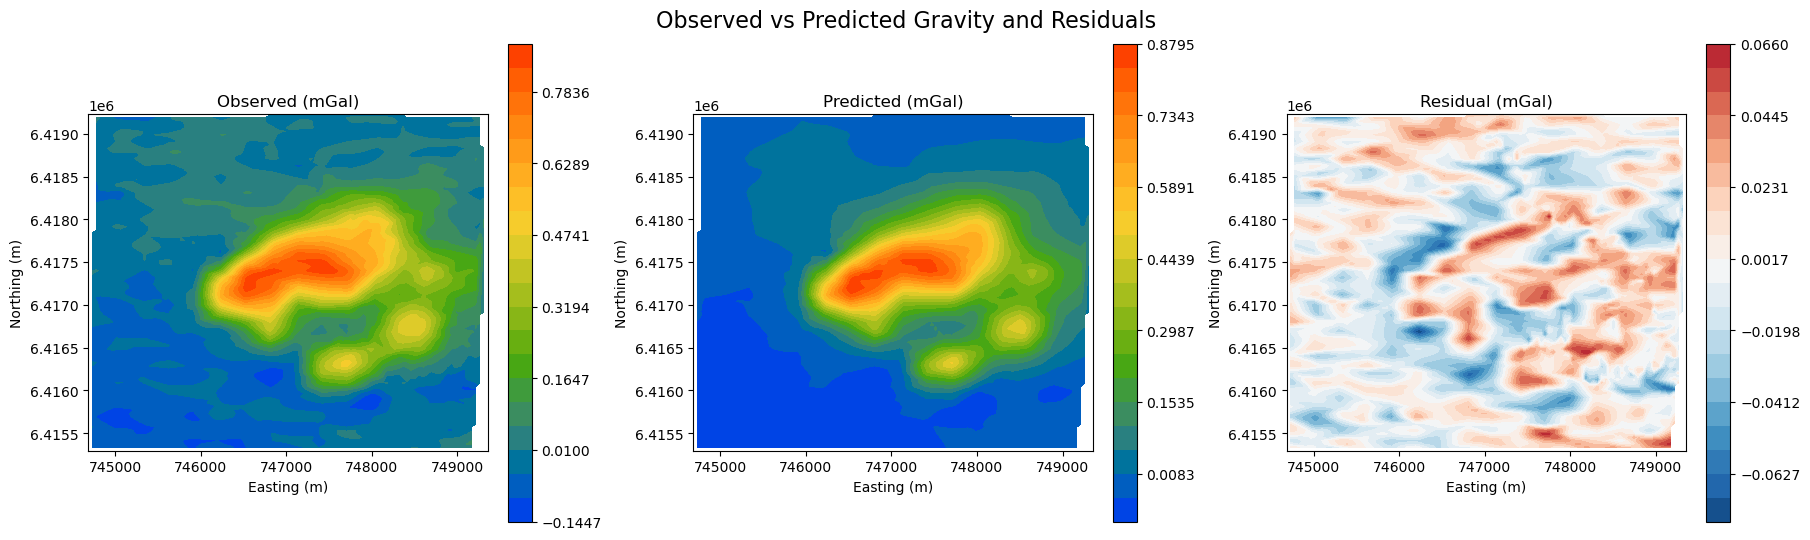

In [27]:
# Validate observed vs predicted vs residual
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

titles = ["Observed (mGal)", "Predicted (mGal)", "Residual (mGal)"]

# Predicted data back to original convention (i.e. dpred times -1) for plotting
dpred = inv_problem.dpred[0]
dpred_orig = dpred * -1

# Compute residual
residual = grav_survey[:, -1] - dpred_orig

data_list = [
    grav_survey[:, -1],  # Observed
    dpred_orig,  # Predicted (original sign convention)
    residual,  # Residual
]

for ax, title, data in zip(axes, titles, data_list, strict=False):
    if data is residual:
        vlim = np.nanmax(np.abs(data))
        norm = mcolors.TwoSlopeNorm(vmin=-vlim, vcenter=0, vmax=vlim)
        contourOpts = {"cmap": "RdBu_r", "norm": norm}
    else:
        contourOpts = {"cmap": cc.m_CET_R2}
    im = plot2Ddata(
        grav_survey[:, :2], data, ax=ax, ncontour=20, contourOpts=contourOpts
    )
    ax.set_title(title)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    plt.colorbar(im[0], ax=ax, orientation="vertical")

plt.suptitle("Observed vs Predicted Gravity and Residuals", fontsize=16, y=1.05)
plt.show()

#### Profile Plot

It is always useful to plot the results along a selected profile to visualize the observed and predicted data and data uncertainties. It helps with assessing the quality of the fit, potential overfit or underfit.

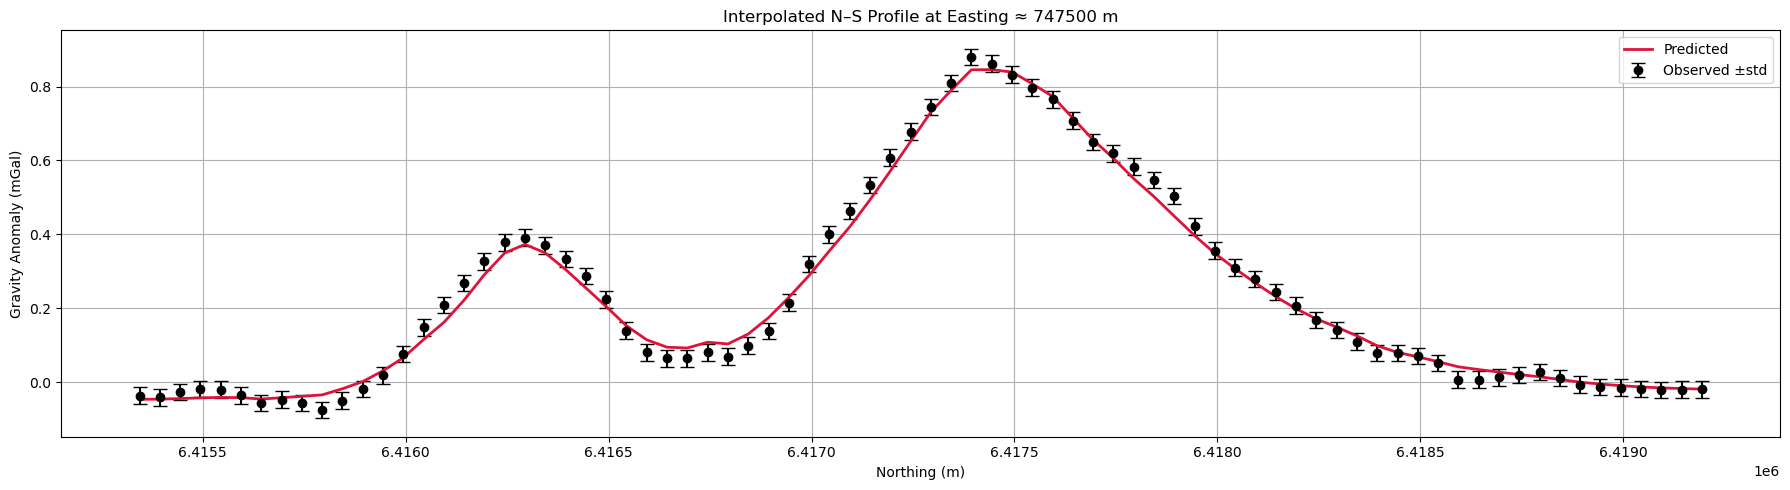

In [28]:
# Inputs
xy, obs, pred, err = grav_survey[:, :2], grav_survey[:, -1], dpred_orig, uncertainties
profile_east, grid_res = 747500, 50  # Profile location and resolution

# Attention: This is an interpolated profile plot, not a direct data extraction
# Create regular grid
xi = np.arange(xy[:, 0].min(), xy[:, 0].max(), grid_res)
yi = np.arange(xy[:, 1].min(), xy[:, 1].max(), grid_res)
grid_x, grid_y = np.meshgrid(xi, yi)

# Interpolate to grid
obs_grid = griddata(xy, obs, (grid_x, grid_y), method="linear")
pred_grid = griddata(xy, pred, (grid_x, grid_y), method="linear")
err_grid = griddata(xy, err, (grid_x, grid_y), method="linear")

# Extract profile at closest Easting
col_idx = np.argmin(np.abs(xi - profile_east))

y_profile = yi
obs_profile = obs_grid[:, col_idx]
pred_profile = pred_grid[:, col_idx]
err_profile = err_grid[:, col_idx]

# Remove NaNs (from interpolation gaps)
mask = ~np.isnan(obs_profile) & ~np.isnan(pred_profile) & ~np.isnan(err_profile)
y_profile, obs_profile, pred_profile, err_profile = (
    y_profile[mask],
    obs_profile[mask],
    pred_profile[mask],
    err_profile[mask],
)

# Plot
plt.figure(figsize=(18, 5))
plt.errorbar(
    y_profile,
    obs_profile,
    yerr=err_profile,
    fmt="o",
    color="k",
    capsize=5,
    label="Observed ±std",
)
plt.plot(y_profile, pred_profile, "-", color="crimson", lw=2, label="Predicted")

plt.xlabel("Northing (m)")
plt.ylabel("Gravity Anomaly (mGal)")
plt.title(f"Interpolated N-S Profile at Easting ≈ {profile_east} m")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

While there might still be some correlated signal in the residuals, overall the data fit is good. 
We can move on to interpretating the model.

### Models

The inversion took 13 iterations to reach the target misfit, followed by 12 iterations to increase sparsity. The figure below shows horizontal and vertical sections through both solutions. 

See the [Regularization Section](https://mirageoscience-simpeg-drivers.readthedocs-hosted.com/en/geopy-2297/inversion/regularization.html#regularization) for more details on sparsity constraints.

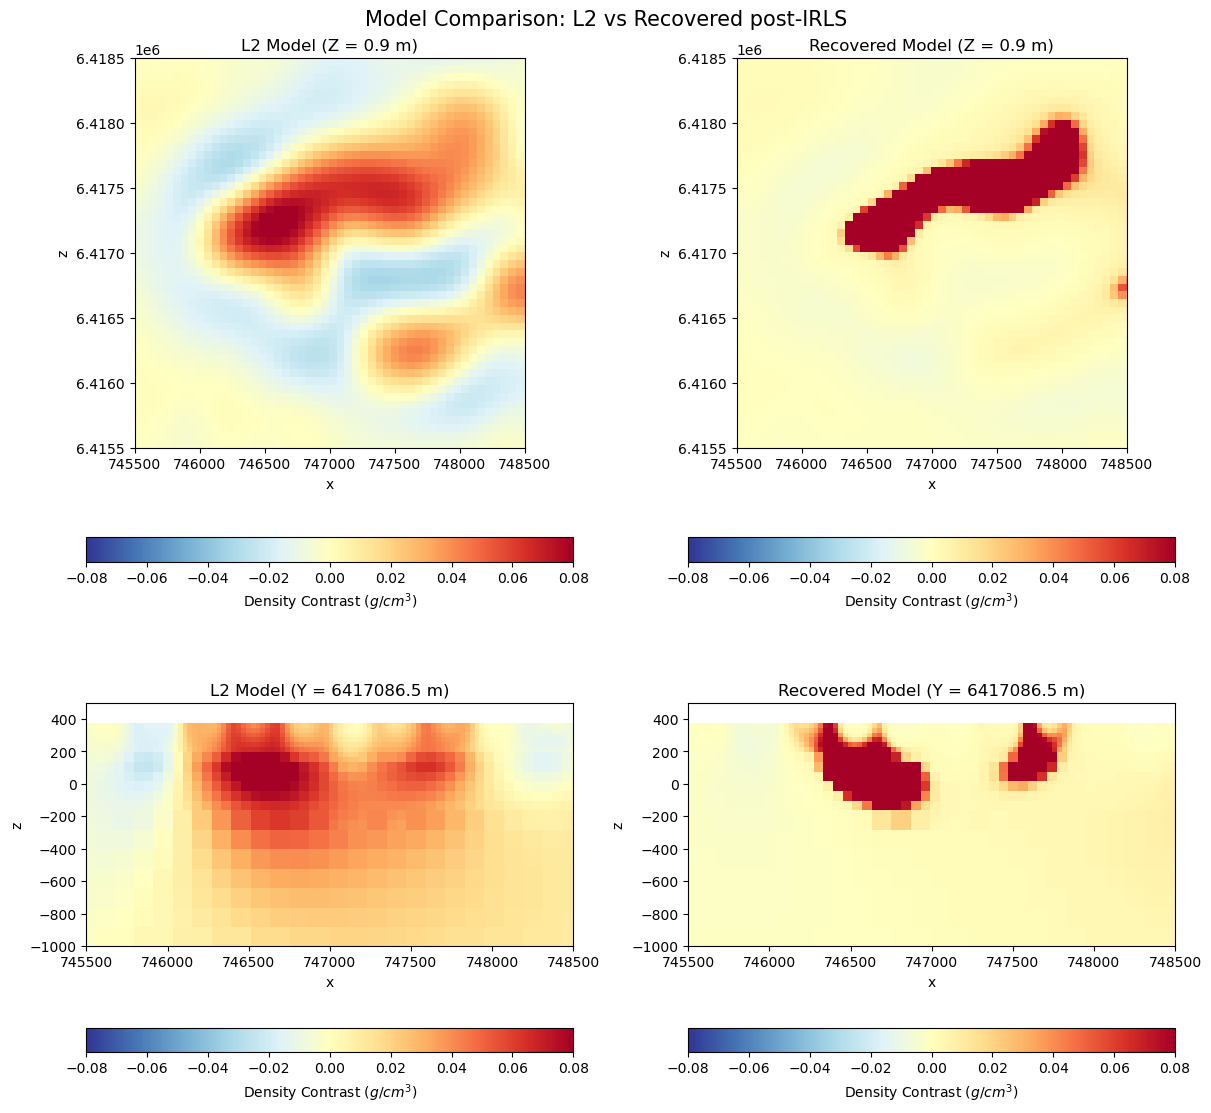

In [29]:
# Map models to full mesh with inactive cells set to np.nan
plotting_map = simpeg.maps.InjectActiveCells(grav_octree, active, np.nan)
model_l2, model_rec = plotting_map * inv_problem.l2model, plotting_map * rec_model

# Shared color scale and slice indices
colour_norm = TwoSlopeNorm(vmin=-0.08, vcenter=0, vmax=0.08)
z_ind = 85
z_val = grav_octree.cell_centers_z[z_ind]
y_val = np.median(grav_survey[:, 1])

# Limit plotting extents
extent_xy = [745500, 748500]
extent_z = [-1000, 500]

# Set up figure with custom row heights
fig, axes = plt.subplots(
    2,
    2,
    figsize=(12, 11),
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.2, 1]},
)

# Define what to plot: (model, normal, index/None, axis, title)
slices = [
    (model_l2, "Z", z_ind, axes[0, 0], f"L2 Model (Z = {z_val:.1f} m)"),
    (model_l2, "Y", None, axes[1, 0], f"L2 Model (Y = {y_val:.1f} m)"),
    (model_rec, "Z", z_ind, axes[0, 1], f"Recovered Model (Z = {z_val:.1f} m)"),
    (model_rec, "Y", None, axes[1, 1], f"Recovered Model (Y = {y_val:.1f} m)"),
]

# Plot all slices
# Loop through each slice definition (Z or Y) and plot
for model, normal, ind, ax, title in slices:
    im = grav_octree.plot_slice(
        model,
        normal=normal,
        ind=ind,
        ax=ax,
        pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": colour_norm},
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlim(extent_xy)
    ax.set_ylim([6415500, 6418500] if normal == "Z" else extent_z)
    ax.set_aspect("equal")
    plt.colorbar(
        im[0],
        ax=ax,
        orientation="horizontal",
        pad=0.1,
        label="Density Contrast ($g/cm^3$)",
    )

fig.suptitle("Model Comparison: L2 vs Recovered post-IRLS", fontsize=15)
plt.show()

### Results

Key observations from the inversion:

 - Convergence to the target data misfit ($\phi_d$) was achieved after 13 iterations.
 - The following 12 iterations have increased the model complexity ($\phi_m$) but preserved the data fit ($\phi_d$).
 - Most of the important gravity anomalies appear to be reproduced by the final model.

The smooth solution (iteration 13) indicates the presence of a dense anomaly extending with depth, with a density contrast ranging from approximately −0.1 to 0.04 g/cm³ relative to the background. Localized negative anomalies around the main positive body are likely artifacts of the smoothness constraint and absence of hard `bounds` on the model. Some smaller "fuzzy" anomalies are visible at the margins.  

As an alternative solution, the compact model (iteration 25) recovers a well-defined dense body within a mostly uniform background.The inferred density contrasts are stronger, ranging from −0.5 to 0.0 g/cm³, and more clearly delineate the target structure.
